![sutd](imgs/sutd.png)
## <center>50.040 Natural Language Processing, Summer 2019<center>
<center>**Homework 3**

<center>**Due 7 August 2019, 5pm** <center>

**Write your student ID and name**

ID: 1002323

Name: Woong Wen Tat

Students whom you have discussed with (if any):

### Requirements:
- Use Python to complete this homework.
- Please list students with whom you have discussed (if any).
- Follow the honor code strictly.
- Submit this ipynb file on eDimension before the deadline.

In this homework, we'll implement IBM Model 1 using the expectation–maximization (EM) algorithm. We need to estimate the  translation probabilities $t(f|e)$ on a parallel corpus, where $e$ is a word from the English sentences and $f$ is a word from the corresponding foreign sentences. 

Note that there's a constraint for such probabilities:
$$\sum_f t(f|e)=1  \ \ \ (1)$$

**We'll use this constraint when initializing the translation probabilities in subsequent tasks.**

## Data
We'll use the English-French parallel corpus under the folder "data/en-fr", which contains a set of translation instances. As can be seen below each instance consists of an English-French sentence pair (note that we are translating from French into English, but as we discussed in class, when working on the translation model using IBM model 1, we are interested in generating French from English).



    Hop in.	Montez.
    Hug me.	Serre-moi dans tes bras !
    I left.	Je suis parti.

The dataset is obtained from [MXNET](http://data.mxnet.io/data/fra-eng.zip). Please run the provided code below to obtain the preprocessed English sentences and French sentences. Do not perform any further preprocessing. 


In [1]:
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
path = 'data/en-fr/en-fr.txt'
with open(path, encoding='utf8') as f:
    raw_text = f.read()

#Original code from 
#https://www.d2l.ai/chapter_recurrent-neural-networks
def preprocess_nmt(text):
    '''
    Arg:
        text: parallel text, string
    Return:
        out: preprocessed text, string
    '''
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: (
        True if char in (',', '!', '.') and prev_char != ' ' else False)
    out = [' '+char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text.lower())]
    out = ''.join(out)
    return out

text = preprocess_nmt(raw_text)

def tokenize_nmt(text, num_examples = None):
    '''
    Args:
        text: parallel text, string
        num_examples: number of examples to be selected, int
    Returns:
        left: English sentences, list
        right: French sentences, list
    '''
    left, right = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            left.append(parts[0].split(' '))
            right.append(parts[1].split(' '))
    return left, right


In [3]:
#English sentences and corresponding French sentences
#Each sentence has been preprocessed and tokenized
english_sents, french_sents = tokenize_nmt(text)


### Task 1 (3 points)
Find out all the possible word pairs $(e, f)$ that appear in all the instances of the English-French dataset, and list down the 10 most frequent pairs. Also count the number of unique pairs. Note that we need to pad each English sentence with the special token "NULL" at the beginning.


In [4]:
from copy import deepcopy

trans_dict = Counter()

for i in range(len(english_sents)):
    new_english_sent = deepcopy(english_sents[i])
    new_english_sent.insert(0, "NULL")
    
    for e in new_english_sent:
        for f in french_sents[i]:
            trans_dict[(e,f)] += 1

print(len(trans_dict))
print (trans_dict.most_common(10))

1402126
[(('.', '.'), 136734), (('NULL', '.'), 135221), (('i', '.'), 43189), (('NULL', 'je'), 39821), (('.', 'je'), 39096), (('NULL', 'de'), 35073), (('i', 'je'), 34415), (('to', '.'), 31647), (('.', 'de'), 30490), (('the', '.'), 29170)]


## Hard EM algorithm

### Task 2 (6 points)
Based on the word pairs obtained in Task 1, implement a hard EM algorithm to calculate the  translation probabilities  $t(f|e)$ on the English-French corpus. Initialize the probabilities randomly under the constraint in Equation 1. Set the maximum iteration number as 10. 

It is possible that in the hard EM algorithm a word $\tilde{e}$ from an English sentence may not be aligned with any word from the corresponding French sentence. In this case, let us set the corresponding probabilities $t(f|\tilde{e})=\frac{1}{|V_f|}$ where $|V_f|$ is the size of the French vocabulary (in this case, the number of unique French words that ever appear in the training parallel corpus).

In [5]:
en_vocab = []
fr_vocab = []

for i in range(len(english_sents)):
    for e in english_sents[i]:
        en_vocab.append(e)
    for f in french_sents[i]:
        fr_vocab.append(f)

en_vocab.append('NULL')
en_vocab = set(en_vocab)
fr_vocab = set(fr_vocab)

In [6]:
from collections import defaultdict
np.random.seed(1337)

t = defaultdict(lambda: defaultdict(float))      #t(f|e)
sum_t = defaultdict(float)                       #normalize t

for (e,f) in trans_dict.keys():
    t[e][f] = np.random.randint(10000)
    sum_t[e] += t[e][f]

for e in t.keys():
    for f in t[e].keys():
        t[e][f] /= sum_t[e]            

In [7]:
max_iter = 10
num_sents = len(french_sents)
fr_vocab_len = len(fr_vocab)

for i in range(max_iter):
    print ("Iteration ", i+1)
    count = defaultdict(float)                       #count(f, e)
    count_e = defaultdict(float)                     #count(e)
    
    
    ### EXPECTATION ###
    print ("expectation")
    for j in range(num_sents):
        new_english_sent = deepcopy(english_sents[j])
        new_english_sent.insert(0, "NULL")
        visited_english_words = [False for _ in range(len(new_english_sent))]
        unvisited_t = defaultdict(lambda: defaultdict(float))
        
        # for each french sentence, find
        # the best english alignment based on t
        for f in french_sents[j]:
            max_prob = 0
            max_index = None
            for index, e in enumerate(new_english_sent):                    
                if t[e][f] > max_prob:
                    max_prob = t[e][f]
                    max_index = index
            visited_english_words[max_index] = True
        
        # check for unused english words
        # if it exists, append it to unvisited list
        for x in range(len(new_english_sent)):
            if not visited_english_words[x]:
                for f in french_sents[j]:
                    unvisited_t[new_english_sent[x]][f] = 1/fr_vocab_len
                
        # use the new t in finding alignments again
        for f in french_sents[j]:
            max_prob = 0
            max_e = None
            max_index = None
            for index, e in enumerate(new_english_sent):
                if visited_english_words[index]:
                    prob = t[e][f]
                else:
                    prob = unvisited_t[e][f]
                if prob > max_prob:
                    max_prob = t[e][f]
                    max_e = e
                    max_index = index
            count[(f, max_e)] += 1
            count_e[max_e] += 1
    
    ### MAXIMIZATION ###
    print ("maximization")
    for e in t.keys():
        for f in t[e].keys():
            try:
                t[e][f] = count[(f, e)]/count_e[e]
            except Exception as ex: 
                # divide by zero error because of some e that is
                # unmatched in all sentences, we retain the old t
                pass

Iteration  1
expectation
maximization
Iteration  2
expectation
maximization
Iteration  3
expectation
maximization
Iteration  4
expectation
maximization
Iteration  5
expectation
maximization
Iteration  6
expectation
maximization
Iteration  7
expectation
maximization
Iteration  8
expectation
maximization
Iteration  9
expectation
maximization
Iteration  10
expectation
maximization


### Task 3 (3 points)
Using 2D-heatmap, visualize the word alignment (namely $t(f|e)$) for each of the instances below:

    NULL tom loves chocolate .   tom adore le chocolat .    
    NULL it was a very exciting game .   c'était un jeu vraiment très excitant .  
    NULL i'm sorry to have kept you waiting for such a long time .   je suis désolé de vous avoir fait attendre aussi longtemps .  
    
Note that you need to label the x-axis (horizontal axis) with the English words and the y-axis (vertical axis) with the French words (please do not change the word orders for both sentences; see the sample heatmap below).

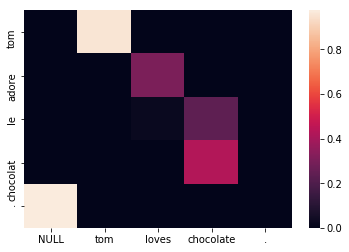

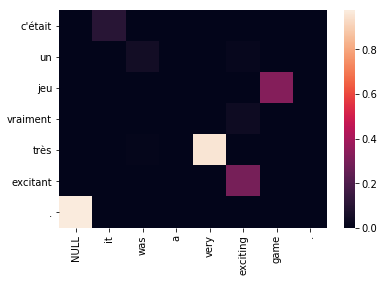

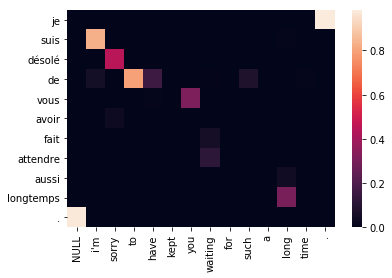

In [8]:
import matplotlib.pyplot as plt
import numpy as np

en = [["NULL", "tom", "loves", "chocolate", "."],["NULL", "it", "was", "a", "very", "exciting", "game", "."],["NULL", "i'm", "sorry", "to", "have", "kept", "you", "waiting", "for", "such", "a", "long", "time", "."]]
fr = [["tom", "adore", "le", "chocolat", "."], ["c'était", "un", "jeu", "vraiment", "très", "excitant", "."],["je", "suis", "désolé", "de", "vous", "avoir", "fait", "attendre", "aussi", "longtemps", "."]]


for i in range(len(en)):
    a = np.zeros((len(fr[i]), len(en[i])))
    for j, f in enumerate(fr[i]):
        for k, e in enumerate(en[i]):
            a[j][k] = t[e][f]
    plt.figure()
    sns.heatmap(a, xticklabels=en[i], yticklabels=fr[i])

## Soft EM algorithm

### Task 4 (8 points)
Implement a soft EM algorithm with the translation probabilities $t(f|e)$ randomly initialized under the constraint in Equation 1. Let us use the objective function defined in the slides to check whether our algorithm can converge as expected. The objective of the entire training set is denoted as: 

$$\sum_{k} \sum_{i=1}^{m_k}log(\sum_{j=0}^{n_k}t(f^k_i\mid e^k_j)) \ \ \ (2)$$
where  $m_k$ is the length of the French sentence, $n_k$ is the length of the English sentence in the $k$-th instance.
- Run the soft EM algorithm on the first 10000 instances of the English-French corpus. Display the objective and check whether it is non-descending in the first, say 100 or 1000 iterations (or even more).  If not, it indicates your algorithm has bug and please look into your implementation. (Note that since we are only considering the first 10000 instances, we therefore only need to consider the word pairs $(e, f)$ that appear in these 10000 instances)
- Based on the word translation pairs obtained in Task 1, calculate the probabilities $t(f|e)$ on the entire English-French corpus. Display the objective at each iteration, and set the maximum iteration number as 15.

In [4]:
num_sents = 10000

In [8]:
from copy import deepcopy

trans_dict2 = Counter()

for i in range(num_sents):
    new_english_sent = deepcopy(english_sents[i])
    new_english_sent.insert(0, "NULL")
    
    for e in new_english_sent:
        for f in french_sents[i]:
            trans_dict2[(e,f)] += 1

In [9]:
en_vocab2 = []
fr_vocab2 = []

for i in range(num_sents):
    for e in english_sents[i]:
        en_vocab2.append(e)
    for f in french_sents[i]:
        fr_vocab2.append(f)

en_vocab2.append('NULL')
en_vocab2 = set(en_vocab2)
fr_vocab2 = set(fr_vocab2)

In [10]:
from collections import defaultdict


t2 = defaultdict(lambda: defaultdict(float))      #t(f|e)
sum_t2 = defaultdict(float)                       #normalize t

for (e,f) in trans_dict2.keys():
    t2[e][f] = np.random.randint(10000)
    sum_t2[e] += t2[e][f]

for e in t2.keys():
    for f in t2[e].keys():
        t2[e][f] /= sum_t2[e]        

In [12]:
import math

max_iter = 15

for i in range(max_iter):
    global_count = defaultdict(float)                       #count(f, e)
    global_count_e = defaultdict(float)                     #count(e)
    global_log_score = 0
    
    print ("Iteration ", i+1)
    
    ### EXPECTATION ###
    for j in range(num_sents):
        new_english_sent = deepcopy(english_sents[j])
        new_english_sent.insert(0, "NULL")
        local_count = defaultdict(float)
        sum_t2 = defaultdict(float)
        log_score = 0
        
        # for each french sentence, find
        # the count as a sum of t(f|e)
        for f in french_sents[j]:    
            for e in new_english_sent:
                local_count[(f, e)] += t2[e][f]
                sum_t2[f] += t2[e][f]
            log_score += np.log(sum_t2[f])
        global_log_score += log_score
        
           
        # normalizing and adding sum of counts of e
        for f in set(french_sents[j]):
            for e in set(new_english_sent):
                local_count[(f, e)] /= sum_t2[f]
                global_count[(f, e)] += local_count[(f,e)]
                global_count_e[e] += local_count[(f,e)]
    
    print ("objective: ", global_log_score)
    
    ### MAXIMIZATION ###
    for e in t2.keys():
        for f in t2[e].keys():
            t2[e][f] = global_count[(f, e)]/global_count_e[e]     

Iteration  1
objective:  -40331.073778961145
Iteration  2
objective:  -40321.44871072049
Iteration  3
objective:  -40313.76754113764
Iteration  4
objective:  -40307.50907071151
Iteration  5
objective:  -40302.46747389517
Iteration  6
objective:  -40298.36436140022
Iteration  7
objective:  -40294.901305327156
Iteration  8
objective:  -40291.849851477695
Iteration  9
objective:  -40289.077997546185
Iteration  10
objective:  -40286.63847261407
Iteration  11
objective:  -40284.5893339219
Iteration  12
objective:  -40282.85433751301
Iteration  13
objective:  -40281.35609008595
Iteration  14
objective:  -40280.0496804587
Iteration  15
objective:  -40278.904147770336


### Task 5 (4 points)

Using the word translation probabilities obtained in Task 4, 
- Perform the visualization again for each of the instances in Task 3. 
- Find out the optimal alignment for each of the instances listed in Task 3. List down the optimal alignment word pairs for each instance, namely, align each word in the French sentence to the most relevant word in the corresponding English sentence based on the learned probabilities.

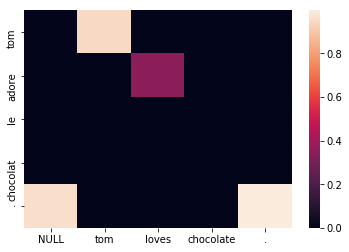

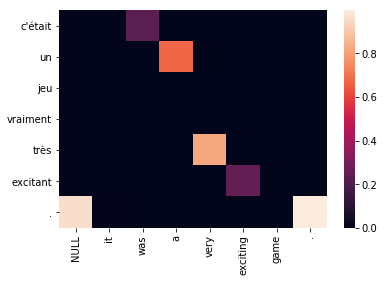

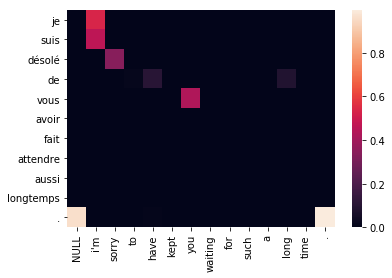

In [13]:
import matplotlib.pyplot as plt
import numpy as np

en = [["NULL", "tom", "loves", "chocolate", "."],["NULL", "it", "was", "a", "very", "exciting", "game", "."],["NULL", "i'm", "sorry", "to", "have", "kept", "you", "waiting", "for", "such", "a", "long", "time", "."]]
fr = [["tom", "adore", "le", "chocolat", "."], ["c'était", "un", "jeu", "vraiment", "très", "excitant", "."],["je", "suis", "désolé", "de", "vous", "avoir", "fait", "attendre", "aussi", "longtemps", "."]]


for i in range(len(en)):
    a = np.zeros((len(fr[i]), len(en[i])))
    for j, f in enumerate(fr[i]):
        for k, e in enumerate(en[i]):
            a[j][k] = t2[e][f]
    plt.figure()
    sns.heatmap(a, xticklabels=en[i], yticklabels=fr[i])

### Task 6 (6 points)

Now let us run the soft EM algorithm on the English-Chinese dataset under the folder "data/en-zh". The dataset is obtained from [OPUS](http://opus.nlpl.eu/). We'll use the provided code below to preprocess and tokenize the sentences. Do not perform any further preprocessing. 
- Pad the English sentences with the token "NULL" at the beginning. 
- Calculate the word translation probabilities $t(f |e)$, where $e$ is an English word and $f$ is a Chinese word. Initialize the probabilities randomly under the constraint in Equation 1.
- Run the algorithm for 10 iterations. Display the objective at each iteration. 
- Visualize the alignment for each of the instances below:
    
        NULL new questions over california water project   加利福尼亚州 水务 工程 的 新 问题
        NULL on wednesday , state lawmakers ordered a state audit of the tunnels-spending as well .    一些 州 议员 也 于 周三 责令 对 隧道 费用 支出 情况 进行 一次 州 内 审计 。
    


    
Hint: We can refer to this [blog](https://xiaobing.home.blog/?p=16) for displaying Chinese characters with Matplotlib.
    

In [15]:
import jieba
from nltk import word_tokenize
def load_en_zh_data(en_path, zh_path):
    '''
    Args:
        en_path: path of the English sentences, string
        zh_path: path of the Chinese sentences, string
    Returns:
        english_sents: English sentences, list
        chinese_sents: Chinese sentences, list
    '''
    english_sents = []
    with open(en_path, encoding='utf8') as f:
        for line in f:
            words = word_tokenize(line.strip('\n').lower())
            english_sents.append(words)

    chinese_sents = []
    with open(zh_path, encoding='utf8') as f:
        for line in f:
            words = list(jieba.cut(line.strip('\n')))
            chinese_sents.append(words)
    return english_sents, chinese_sents

In [16]:
english_sents, chinese_sents = load_en_zh_data("data/en-zh/WMT-News.en-zh.en", "data/en-zh/WMT-News.en-zh.zh")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Lumo\AppData\Local\Temp\jieba.cache
Loading model cost 1.016 seconds.
Prefix dict has been built succesfully.


In [17]:
num_sents = len(english_sents)

In [18]:
from copy import deepcopy
trans_dict3 = Counter()

for i in range(num_sents):
    new_english_sent = deepcopy(english_sents[i])
    new_english_sent.insert(0, "NULL")
    
    for e in new_english_sent:
        for f in chinese_sents[i]:
            trans_dict3[(e,f)] += 1

In [19]:
en_vocab3 = []
zh_vocab = []

for i in range(num_sents):
    for e in english_sents[i]:
        en_vocab3.append(e)
    for f in chinese_sents[i]:
        zh_vocab.append(f)

en_vocab3.append('NULL')
en_vocab3 = set(en_vocab3)
zh_vocab = set(zh_vocab)

In [27]:
from collections import defaultdict


t3 = defaultdict(lambda: defaultdict(float))      #t(f|e)
sum_t3 = defaultdict(float)                       #normalize t

for (e,f) in trans_dict3.keys():
    t3[e][f] = np.random.randint(10000)
    sum_t3[e] += t3[e][f]

for e in t3.keys():
    for f in t3[e].keys():
        t3[e][f] /= sum_t3[e]        

In [29]:
max_iter = 10


for i in range(max_iter):
    global_count = defaultdict(float)                       #count(f, e)
    global_count_e = defaultdict(float)                     #count(e)
    global_log_score = 0
    
    print ("Iteration ", i+1)
    
    ### EXPECTATION ###
    for j in range(num_sents):
        new_english_sent = deepcopy(english_sents[j])
        new_english_sent.insert(0, "NULL")
        local_count = defaultdict(float)
        sum_t3 = defaultdict(float)
        log_score = 0
        
        # for each french sentence, find
        # the count as a sum of t(f|e)
        for f in chinese_sents[j]:    
            for e in new_english_sent:
                local_count[(f, e)] += t3[e][f]
                sum_t3[f] += t3[e][f]
            log_score += np.log(sum_t3[f])
        global_log_score += log_score
        
           
        # normalizing and adding sum of counts of e
        for f in set(chinese_sents[j]):
            for e in set(new_english_sent):
                local_count[(f, e)] /= sum_t3[f]
                global_count[(f, e)] += local_count[(f,e)]
                global_count_e[e] += local_count[(f,e)]
    
    print ("objective: ", global_log_score)
    
    for e in t3.keys():
        for f in t3[e].keys():
            t3[e][f] = global_count[(f, e)]/global_count_e[e]

Iteration  1
objective:  -761329.5316996622
Iteration  2
objective:  -521235.9476753816
Iteration  3
objective:  -403014.0128672035
Iteration  4
objective:  -348979.5974847882
Iteration  5
objective:  -323492.4810628012
Iteration  6
objective:  -310122.4111066356
Iteration  7
objective:  -302294.0624926026
Iteration  8
objective:  -297299.27461019094
Iteration  9
objective:  -293906.31712190586
Iteration  10
objective:  -291493.34389368683


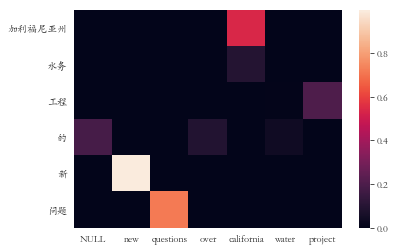

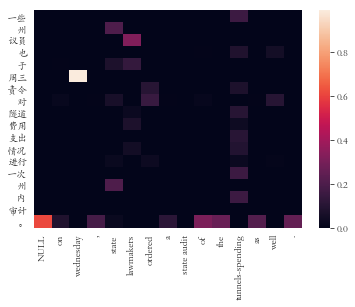

In [52]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['STKaiTi']
mpl.rcParams['font.serif'] = ['STKaiTi']

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['stkaiti', 'Arial']})

en = [["NULL", "new", "questions", "over", "california", "water", "project"],["NULL", "on", "wednesday", ",", "state", "lawmakers", "ordered", "a", "state audit", "of", "the", "tunnels-spending", "as", "well", "."]]
zh = [["加利福尼亚州", "水务", "工程", "的", "新", "问题"],["一些", "州", "议员", "也", "于", "周三", "责令", "对", "隧道", "费用", "支出", "情况", "进行", "一次", "州", "内", "审计", "。"]]


for i in range(len(en)):
    a = np.zeros((len(zh[i]), len(en[i])))
    for j, f in enumerate(zh[i]):
        for k, e in enumerate(en[i]):
            a[j][k] = t3[e][f]
    plt.figure()
    sns.heatmap(a, xticklabels=en[i], yticklabels=fr[i])